# Méthodes numériques

L'application de ces méthodes numériques nécessitent d'avoir d'abord travailler sur la résolution numérique d'équations différentielles d'[ordre 1](https://pcsi3physiquestan.github.io/capacites_numeriques/elec_reponse_o1.html) et [d'ordre 2](https://pcsi3physiquestan.github.io/capacites_numeriques/elec_reponse_o2.html). Une fois que vous aurez traité ces parties, vous pourrez faire les exercices suivant. Les méthodes écrites devront être modifiées pour le deuxième exercice.

## Période d'un pendule simple

__Attention, les angles sous Python sont en radians.__

On considère un pendule simple de longueur $l = 1 \rm{m}$ dans un champ de pesanteur $g = 9.81 \rm{m.s^{-2}}$. On néglige tout frottement.

> 1. Ecrire l'équation différentielle que doit vérifier l'angle $\theta$ que fait la tige avec la verticale descendante puis mettre ce problème sous la forme d'un problème d'Euler $\frac{\rm{d}Y}{\rm{dt}}(t) = F(Y(t), t)$ en précisant les expressions de $Y(t)$ et $F(Y(t), t)$. Quelle est la taille de $Y(t)$.
> 2. En utilisant la fonction native `odeint` de `scipy.integrate` obtenir l'évolution de l'angle $\theta$ sur $30 \rm{s}$ pour une pendule lâché d'un angle $120 ^{\circ}$ sans vitesse initiale.
> 3. \*Ecrire une `periode(alph:float) -> float` qui, après avoir résolution le problème d'Euler précédent pour un pendule lâché sans vitesse initiale d'un angle `alph` sur une durée de $100 s\rm{s}$, déterminer la période du signal. Pour cela, vous devrez :
>     * Déterminer N le nombre de changement de signe de $\theta(t)$ (dont le nombre d'annulations).
>     * La durée $\delta t$ entre la première et la dernière annulation.
>     * La période $T = \frac{2\delta t}{N-1}$
> 4. \*Tracer la période des oscillations du pendule pour des angles entre $alph = 10 ^{\circ}$ et $alph = 150 ^{\circ}$ par pas de $10 ^{\circ}$. Analyser.

```{dropdown}
En posant le vecteur :

$$
Y(t) = 
\begin{matrix}
    \theta(t)\\
    \dot \theta(t)
\end{matrix}
$$

On obtient le système d'équations:

$$
\dot Y(t) =
\begin{matrix}
    \dot \theta(t)\\
    - \frac{g}{l}\sin \theta(t)
\end{matrix}
$$
```

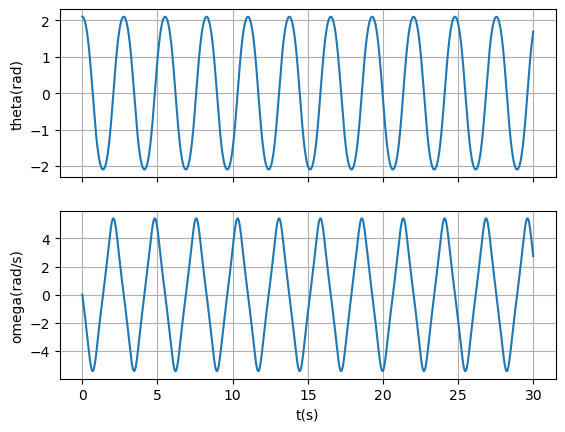

In [1]:
from numpy import *
from matplotlib.pyplot import *
from scipy.integrate import odeint

def f_euler(t, Y):  # Fonction du schéma d'Euler
    l = 1
    g = 9.81
    return np.array([Y[1], -g / l * np.sin(Y[0])])

Y0 = 120
V0 = 0
Y = [Y0/180*np.pi, V0]  # CI en passant l'angle en radians
tmax = 30
pas = 1e-2  # Pas petit devant la période (minorée par sqrt(g/l) = 2s)
tks = np.arange(0, tmax, pas)
yks = odeint(f_euler, Y, tks, tfirst=True)

angles = yks[:, 0]  # Pour avoir uniquement les données de l'angle

# Supplément : on va tracer position angulaire et vitesse angulaire
f, ax = subplots(2, 1, sharex='col')  # Deux graphiques sur deux lignes avec les mêmes abscisses
ax[0].set_ylabel('theta(rad)')
ax[1].set_ylabel('omega(rad/s)')
ax[1].set_xlabel('t(s)')
ax[0].plot(tks, yks[:,0])
ax[1].plot(tks, yks[:,1])
ax[0].grid()
ax[1].grid()
show()

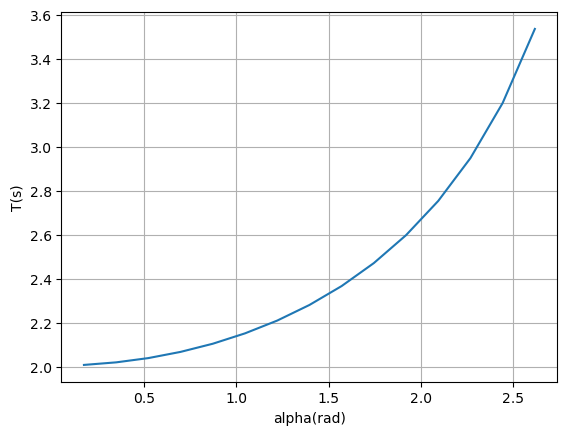

In [2]:
def periode(alph):
    l=1
    g =9.81
    V0 = 0
    Y = [alph, V0]  # CI, alpah devra être en radians
    tmax = 100
    pas = 1e-2  # Pas petit devant la période (minorée par sqrt(g/l) = 2s)
    tks = np.arange(0, tmax, pas)
    yks = odeint(f_euler, Y, tks, tfirst=True)[:,0]
    Ns = 0
    deltat = [0,0]  # On va stocker le temps du premier et du dernier changement de signe
    for i in range(1, len(yks)):
        if yks[i]*yks[i-1] < 0:  # Test de changement de signe
            if Ns==0:  # Stockage du premier temps
                deltat [0]= tks[i]
            Ns += 1  # Décompte du nombre de changement de signe
            deltat[1] = tks[i]  # Stockage du temps du dernier changement de signe détecté
    return 2 * (deltat[1] - deltat[0]) / (Ns - 1)

alphs = np.arange(10, 160, 10) * np.pi / 180  # On passe les valeurs d'angle en radians

pers = []  # On va y stocker les périodes
for alph in alphs:
    pers.append(periode(alph))

f, ax = subplots()
ax.set_xlabel('alpha(rad)')
ax.set_ylabel('T(s)')
ax.plot(alphs, pers)
ax.grid()
show()

## Portée d'un tir de badminton

La trajectoire d'un volant de badminton (masse $m = 5.3 \rm{g}$) nécessite de prendre en compte les frottements de l'air. La forme du volant et sa vitesse impose un régime d'écoulement d'air turbulent et la force de frottement de l'air sur le volant est alors modélisée par:

$$
\overrightarrow{f}_v = - \frac{1}{2} \rho \pi R^2 C_x \left \| \overrightarrow{v}\right \| \overrightarrow{v}
$$

```{margin}
_La physique du sport_, Caroline Cohen, 2014
```
avec $\rho = 1.29 \rm{kg.m^{-3}}$  la masse volumique de l'air, $R = 3.4 \rm{cm}$ le rayon du volant de badminton (face au flux d'air), $C_x = 0.65$ le coefficient de trainée du volant dans l'air et $\overrightarrow{v}$ la vitesse du volant dans l'air.

Soumis de plus à la pesanteur $g = 9.81 \rm{m.s^{-2}}$, l'étude théorique de la trajectoire du volant est délicate. On se propose de l'étude de manière numérique pour une vitesse initiale $V_0 = 60 \rm{m.s^{-1}}$ et un angle de départ $alph$ variable. L'altitude initiale du volant est $h_0 = 2\rm{m}$.

> 1. Ecrire l'équation différentielle qui régit l'évolution du volant de badmintion et mettre ce problème sous la forme d'un problème d'Euler $\frac{\rm{d}Y}{\rm{dt}}(t) = F(t, Y(t))$ en précisant les expressions de $Y(t)$ et $F(t, Y(t))$. Quelle est la taille de $Y(t)$.
> 2. Ecrire une fonction `euler(f:callable, v0:float, alph:float, pas:float) -> numpy.ndarray` qui réalise le schéma d'intégration d'Euler explicite et renvoie dans un seul tableau numpy l'évolution des coordonnées de position et de vitesse pour une vitesse initiale `v0` et un angle `alph` initial. __L'intégration ne devra pas s'arrêter pour un temps défini mais lorsque l'altitude du volant devient négative.__
> 3. Tracer la trajectoire du volant pour un angle de $45 ^{\circ}$ en choisissant un pas d'intégration correct.
> 4. Ecrire une fonction `portee(alph:float)` qui renvoie la portée estimée du tir pour un angle `alph`.
> 5. Tracer la portée du tir en fonction de l'angle $alph$ et déterminer la gamme d'angle acceptable pour un retour de fond de court où la portée doit être entre 9m et 12m.

```{dropdown}
En posant le vecteur :

$$
Y(t) = 
\begin{matrix}
    x(t)\\
    z(t)\\    
    \dot x(t)\\
    \dot z(t)
\end{matrix}
$$

On obtient le système d'équations:

$$
\dot Y(t) =
\begin{matrix}
    \dot x(t)\\
    \dot z(t)\\
    - \frac{1}{2m}\rho \pi R^2 C_x \sqrt{\dot x(t)^2 + \dot z(t)^2}\dot x(t)\\
    - g - \frac{1}{2m}\rho \pi R^2 C_x \sqrt{\dot x(t)^2 + \dot z(t)^2}\dot z(t)
\end{matrix}
$$
```

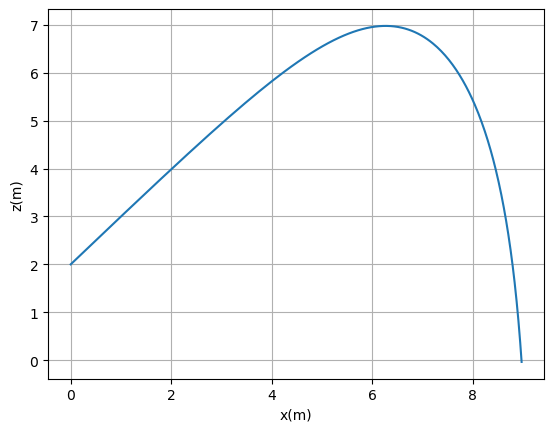

In [3]:

"""
Les bibliothèques scientifiques ne sont pas importées
car elles ont été importées pour l'exercice précédent.
"""

def f_bad(t, Y):  # Y est un vecteur de taille 2
    g = 9.81
    Cx = 0.65
    rho = 1.29
    R = 3.4e-2
    m = 5.3e-3
    coef = -1/(2 * m) * rho * Cx * pi * R ** 2
    v = sqrt(Y[2] ** 2 + Y[3]**2)
    return np.array([Y[2], Y[3], coef * v * Y[2], -g + coef * v * Y[3]])

def euler(f, v0, alpha, pas):
    h0 = 2  # Hauteur de départ
    Y0 = array([0, h0, v0 * cos(alpha), v0 * sin(alpha)])  # Vecteur numpy pour faciliter les opérations mathématiques
    tk = [0]
    yk = [Y0]
    while yk[-1][1]>=0:
        yk.append(yk[-1] + pas * f(tk[-1], yk[-1]))
        tk.append(tk[-1] + pas)
    return array(yk)


V0 = 60
alpha0 = 45 / 180 * pi
pas = 1e-2
yk = euler(f_bad, V0, alpha0, pas)
plot(yk[:, 0], yk[:,1])
xlabel('x(m)')
ylabel('z(m)')
grid()

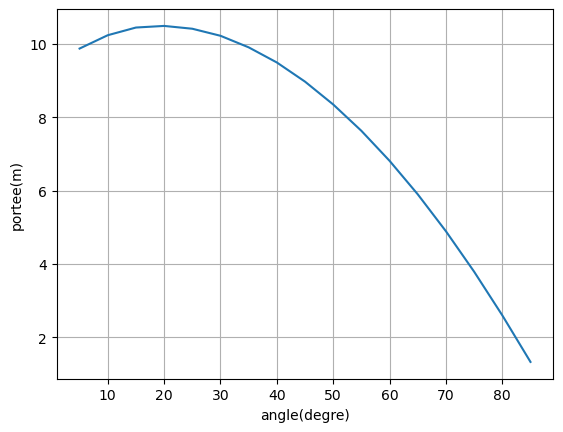

In [4]:
def portee(alph):
    V0 = 60
    pas = 1e-2
    yk = euler(f_bad, V0, alph, pas)
    return yk[-1, 0]  # La portée est la dernière valeur de x.

alphs = np.arange(5, 90, 5)  # Angle en degrés de 5 à 85 degrés
alphrs = alphs /180 * pi  # Passage en radians

portees = []
for alph in alphrs:
    portees.append(portee(alph))

plot(alphs, portees)
xlabel('angle(degre)')
ylabel('portee(m)')
grid()

In [5]:
"""
Le tracé précédent montre qu'on ne dépassera pas 12m, on cherche donc à être en dessus de 9m
"""
"""On va réaliser une dichotomie
mais basée sur les indices des angles"""
imin = 0
imax = len(portees) - 1

while (imax-imin) > 1: # On se ramène à deux indices possibles
    imid = int((imax+imin) / 2)  # On prend l'indice médian, c'est un entier
    if portees[imid] == 9:
        imax = imid
        imin = imid
    elif portees[imid] > 9: # La portée voulu est dans la partie droite
        imin = imid
    else:
        imax = imid

print(alphs[imax], portees[imax])
print(alphs[imin], portees[imin])

"""On doit donc tirer entre 0 et 45°"""
"""
NOTE : En pratique, il faudrait aussi vérifier que le volant passe le filet
"""

45 8.974193450851331
40 9.497078241692162


'\nNOTE : En pratique, il faudrait aussi vérifier que le volant passe le filet\n'